## CHRONIC KIDNEY DISEASE PREDICTION

### 1. INTRODUCTION
### 2. SUMMARY
### 3. DATA CLEANING AND ANALYZE PREPARATION
### 4. DATA EXPLARATORY
### 5. PRINCIPAL COMPONENTS ANALYSIS (PCA)
### 6. DATA RESAMPLING AND  LOGISTIC REGRESSION

..............................................................................................................................

### 1. INTRODUCTION

This dataset was recorded in India with 25 parameters within 2 months. The target is state of having Chronic Kidney Disease (CKD) or not. Patients having CKD is shown with 1 and those not having CKD is shown with 0.

The dataset has a lot of missing values and inaccurate information. As the subject is related with health;

- The missing values shouldn't be replaced in order not to cause any undesirable situations,
- Due to the fact that outlier values can be thought as normal in some cases of illnesses, intervals should be kept wide and data should be winsorized as few as possible.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, f1_score
from imblearn.over_sampling import SMOTE, ADASYN

import warnings
warnings.filterwarnings('ignore')

In [2]:
kidney = pd.read_csv(".\\kidney_disease.csv")

### 2. SUMMARY
#### 2.a. Columns and Data Input
Seeing the table and data in it to have some knowledge. The table is transposed to study easily.

In [3]:
kidney.head().T

,0,1,2,3,4
id,0,1,2,3,4
age,48,7,62,48,51
bp,80,50,80,70,80
sg,1.02,1.02,1.01,1.005,1.01
al,1,4,2,4,2
su,0,0,3,0,0
rbc,NaN,NaN,normal,normal,normal
pc,normal,normal,normal,abnormal,normal
pcc,notpresent,notpresent,notpresent,present,notpresent
ba,notpresent,notpresent,notpresent,notpresent,notpresent


#### 2.b. Data Quantities and Types of Columns
There are a lot of missing values, especially in some columns. Besides, some values are stored as string. String values are categorical, e.g. yes-no, normal-abnormal, absent-present.

In [4]:
kidney.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
id                400 non-null int64
age               391 non-null float64
bp                388 non-null float64
sg                353 non-null float64
al                354 non-null float64
su                351 non-null float64
rbc               248 non-null object
pc                335 non-null object
pcc               396 non-null object
ba                396 non-null object
bgr               356 non-null float64
bu                381 non-null float64
sc                383 non-null float64
sod               313 non-null float64
pot               312 non-null float64
hemo              348 non-null float64
pcv               330 non-null object
wc                295 non-null object
rc                270 non-null object
htn               398 non-null object
dm                398 non-null object
cad               398 non-null object
appet             399 non-null object
pe         

Amounts of missing values can be seen below.

In [5]:
len(kidney)-kidney.count()

id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                70
wc                105
rc                130
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

In [6]:
kidney.describe()

,id,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo
count,400.000000,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000
mean,199.500000,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437
std,115.614301,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587
min,0.000000,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000
25%,99.750000,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000
50%,199.500000,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000
75%,299.250000,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000
max,399.000000,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000


### 3. VDATA CLEANING AND ANALYZE PREPARATION
#### 3.a. Digitizing
String values should be converted to digits so as to make comparisons easily. Undesirable values are replaced with 1, and desired ones with 0.

Some of those convertions could be made with "get_dummies" and "LabelEncoder" methods. Some parameters such as "classification" have different inputs which refer the same category.

In [7]:
kidney[['htn','dm','cad','pe','ane']] = kidney[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})

kidney[['rbc','pc']] = kidney[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})

kidney[['pcc','ba']] = kidney[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})

kidney[['appet']] = kidney[['appet']].replace(to_replace={'good':2,'poor':1,'no':0})

kidney['classification'] = kidney['classification'].replace(to_replace={'ckd':1,'ckd\t':1,'notckd':0,'no':0})

kidney.rename(columns={'classification':'class'},inplace=True)

kidney['pe'] = kidney['pe'].replace(to_replace='good',value=0)

kidney['appet'] = kidney['appet'].replace(to_replace='no',value=0)

kidney['cad'] = kidney['cad'].replace(to_replace='\tno',value=0)

kidney['dm'] = kidney['dm'].replace(to_replace={'\tno':0,'\tyes':1,' yes':1, '':np.nan})

kidney[["pcv", "wc", "rc"]]=kidney[["pcv", "wc", "rc"]].replace(to_replace={'\t?':np.nan})

kidney[["pcv", "wc", "rc"]]=kidney[["pcv", "wc", "rc"]].astype(float)

kidney.drop('id',axis=1,inplace=True)

#### 3.b. Null Values
###### 1st Approach:
Though it can lead to large amount of data loss, it may not be suitable for this dataset to fill missing values. Despite, it can be a better way to omit them. After omitting, there are 158 values left. It is an imbalanced dataset with very too few observations.

In [8]:
kd=kidney.dropna(axis=0)

print("Observations Left      : ", len(kd),"\n")
print("Not Diagnosed with CKD : ",kd["class"].value_counts()[0])
print("Diagnosed with CKD     : ",kd["class"].value_counts()[1])

Observations Left      :  158 

Not Diagnosed with CKD :  115
Diagnosed with CKD     :  43


###### 2nd Approach:
250 observations out of 400 is diagnosed with CKD and 150 of them is not diagnosed. As considered; when someone goes to doctor for some complaints, doctor wants to see related specimen results with his/her doubdts. But, all of them may not directly be related with the diagnosed disease. That means, every disease has its own symptoms and parameters having missing values are out of CKD symptoms. Parameters with the least missing values may have the most relations with the disease.

In [9]:
missing=pd.DataFrame()

CKD_count=len(kidney[kidney["class"]==1])
not_CKD_count=len(kidney[kidney["class"]==0])

for i in kidney.columns:
    row=pd.Series({"not CKD":not_CKD_count - kidney.groupby("class")[i].count()[0],
                   "CKD":CKD_count - kidney.groupby("class")[i].count()[1]},
                   name=i)
    
    missing=missing.append(row)

In [10]:
missing

,CKD,not CKD
age,8.0,1.0
bp,10.0,2.0
sg,42.0,5.0
al,41.0,5.0
su,44.0,5.0
rbc,143.0,9.0
pc,56.0,9.0
pcc,0.0,4.0
ba,0.0,4.0
bgr,38.0,6.0


In [11]:
kd_symptoms=kidney[["pcc", "ba", "htn", "dm", "cad", "appet", "pe", "ane", "class"]]
kd_symptoms=kd_symptoms.dropna(axis=0)
len(kd_symptoms)

393

There are only 7 observations lost which is not important.

#### 3.c. Outliers
Boxplot can help to check outliers' presence. But, note that it is not the official way to do that.

It can be useful to increase "whis" value for the reason mentioned before.

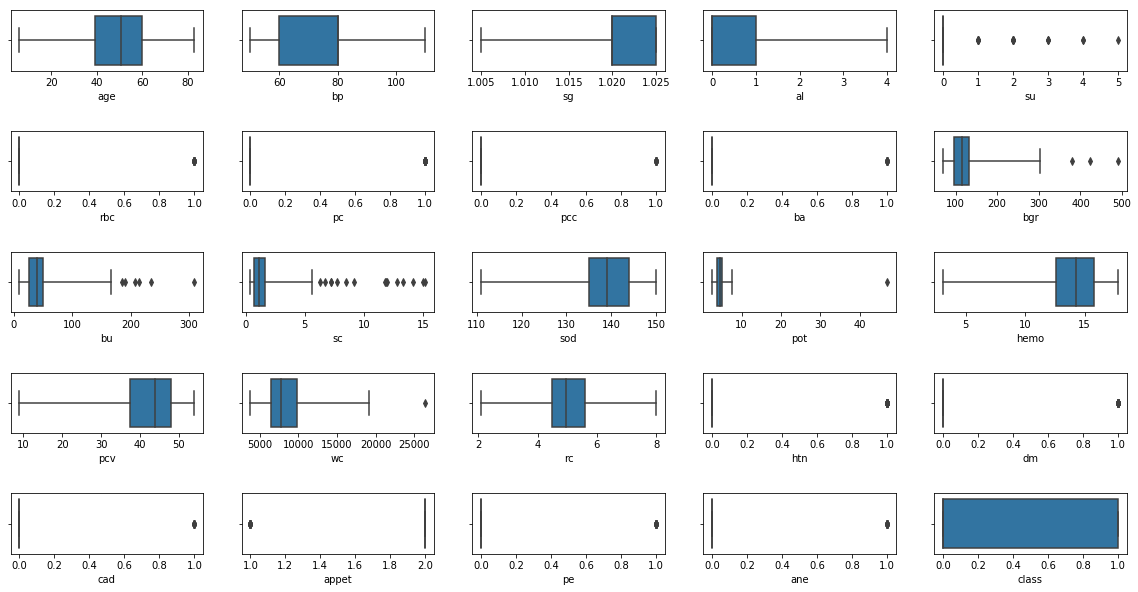

In [12]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=1, wspace=0.2)
for i in range(1,len(kd.columns)+1):
    plt.subplot(5,5,i)
    sns.boxplot(kd.iloc[:,i-1], whis=5)
plt.show()

As seen above, 5 parameters have outliers to be winsorized.

In [13]:
kd_wins=kd

kd_wins["bgr"]=winsorize(kd["bgr"], (0, 0.02))
kd_wins["bu"]=winsorize(kd["bu"], (0, 0.04))
kd_wins["sc"]=winsorize(kd["sc"], (0, 0.1))
kd_wins["pot"]=winsorize(kd["pot"], (0, 0.02))
kd_wins["wc"]=winsorize(kd["wc"], (0, 0.01))

### 4. DATA EXPLORATORY
#### 4.a. Distributions of Parameters
Distributions of parameters according to people diagnosed and not diagnosed with CKD.

In [14]:
parameters={'age':'age', 'bp':'bloodpressure', 'sg':'specificgravity', 'al':'albumin', 'su':'sugar',
            'rbc':'redbloodcells', 'pc':'puscell', 'pcc':'puscellclumps', 'ba':'bacteria', 'bgr':'bloodglucoserandom',
            'bu':'bloodurea', 'sc':'serumcreatinine', 'sod':'sodium', 'pot':'potassium', 'hemo':'hemoglobin',
            'pcv':'packedcellvolume', 'wc':'whitebloodcellcount', 'rc':'redbloodcellcount', 'htn':'hypertension',
            'dm':'diabetesmellitus', 'cad':'coronaryarterydisease', 'appet':'appetite', 'pe':'pedaledema',
            'ane':'anemia', 'class':'class'}

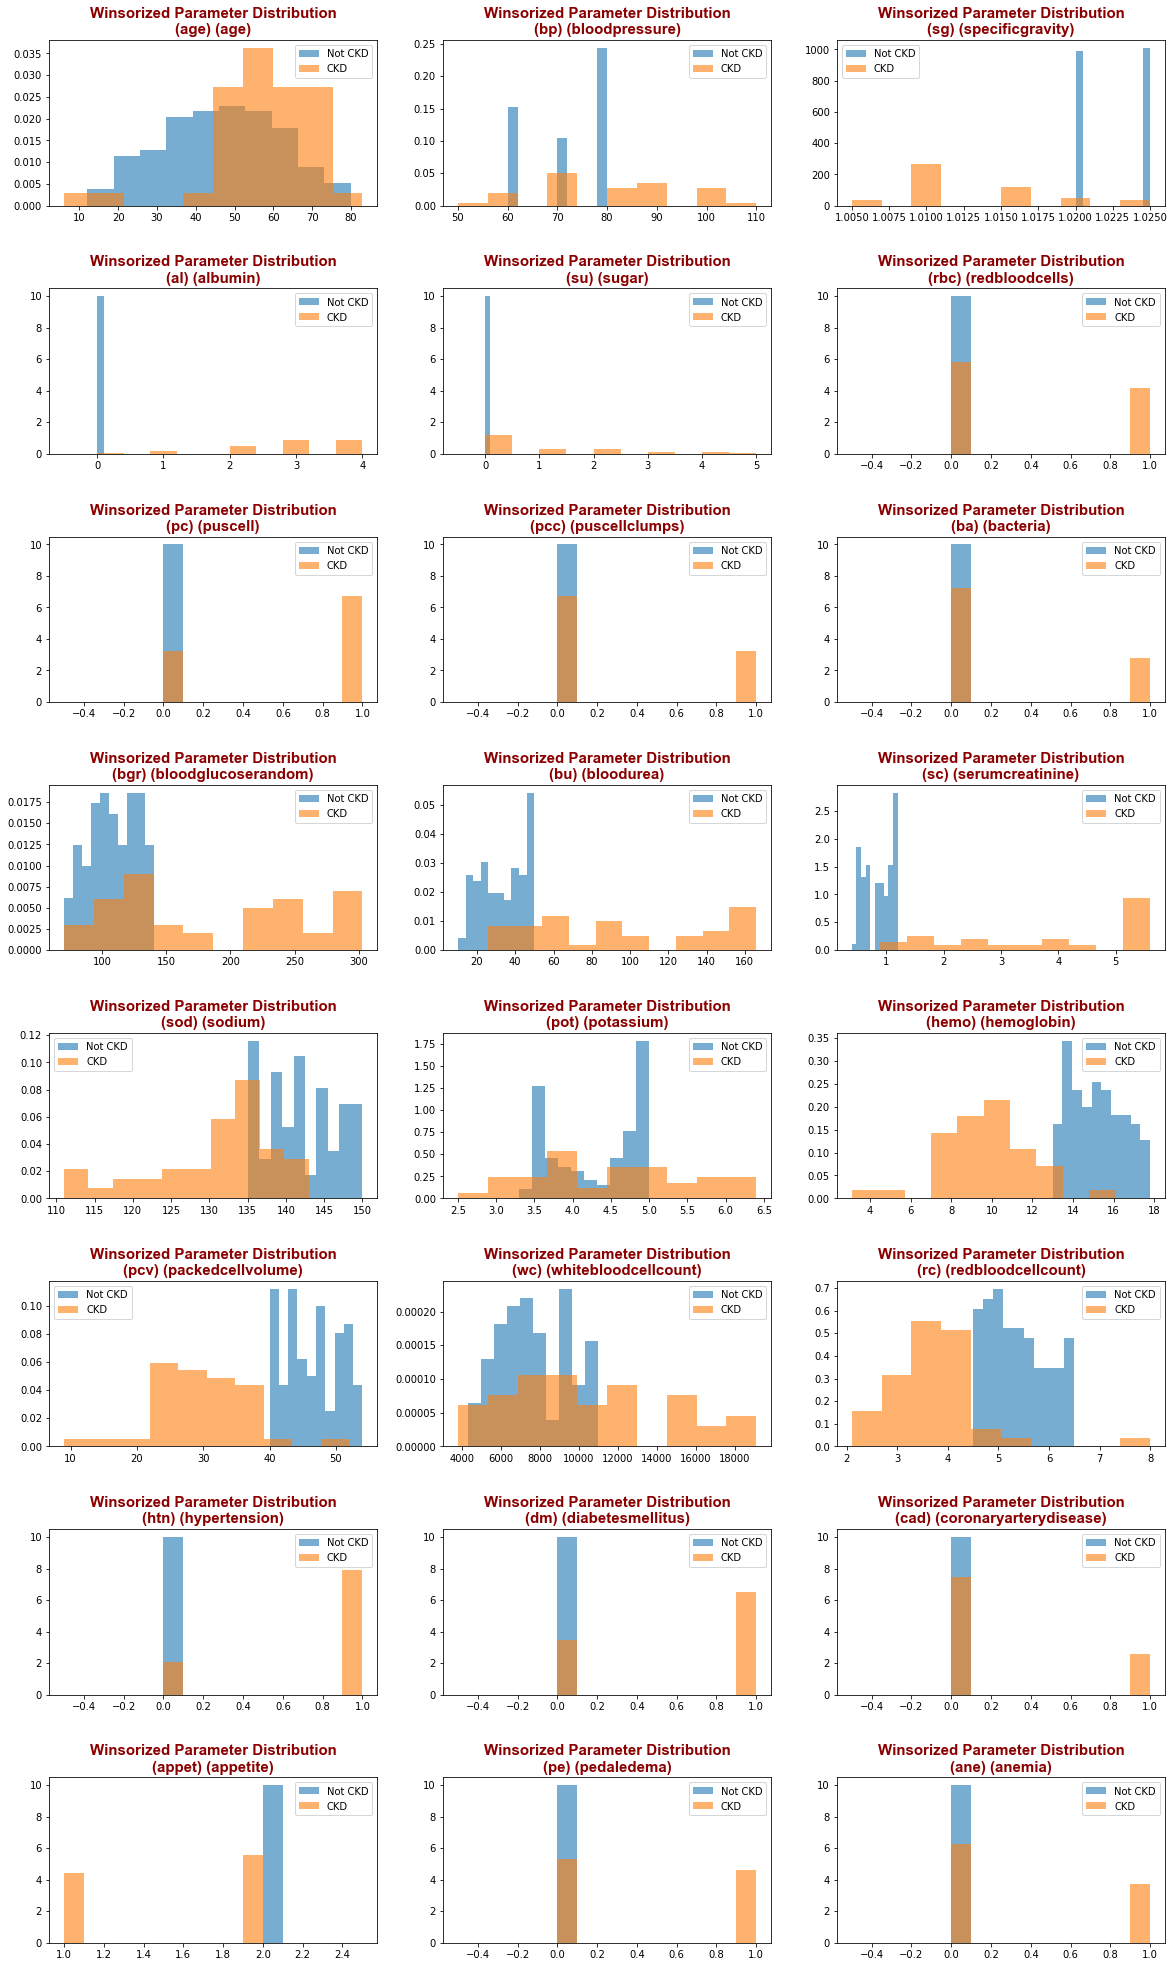

In [15]:
plt.figure(figsize=(20,35))
plt.subplots_adjust(hspace=0.5)
font_header={"family":"arial", "color":"darkred", "weight":"bold", "size":15}

for i in range(0, len(kd_wins.columns)-1):
    plt.subplot(8,3,i+1)
    plt.hist(kd_wins[kd_wins["class"]==0].iloc[:,i], density=True, alpha=0.6)
    plt.hist(kd_wins[kd_wins["class"]==1].iloc[:,i], density=True, alpha=0.6)
    plt.legend(["Not CKD", "CKD"])
    plt.ylabel
    plt.title("Winsorized Parameter Distribution\n({}) ({})".format(kd_wins.columns[i], parameters[kd_wins.columns[i]]), 
              fontdict=font_header)
    
plt.show()

According to tables above, it can be said that people diagnosed with CKD;

- Are between 42-72 years old mostly,
- Have lower ’specificgravity’, ’sodium’, ’hemoglobin’, ’packedcellvolume’ and ’redbloodcellcount’ values,
- Have higher ’albumin’, ’sugar’, ’bloodurea’, ’serumcreatinine’ and ’bloodpressure’ values,
- Can sometimes have ’puscell’ and ’bacteria’ in their bodies,
- Are accompanied ’diabetesmellitus’, ’coronaryarterydisease’, ’appetite’, ’pedaledema’ and ’anemia’ problems.

#### 4.b. Relationship Among Continious Variables

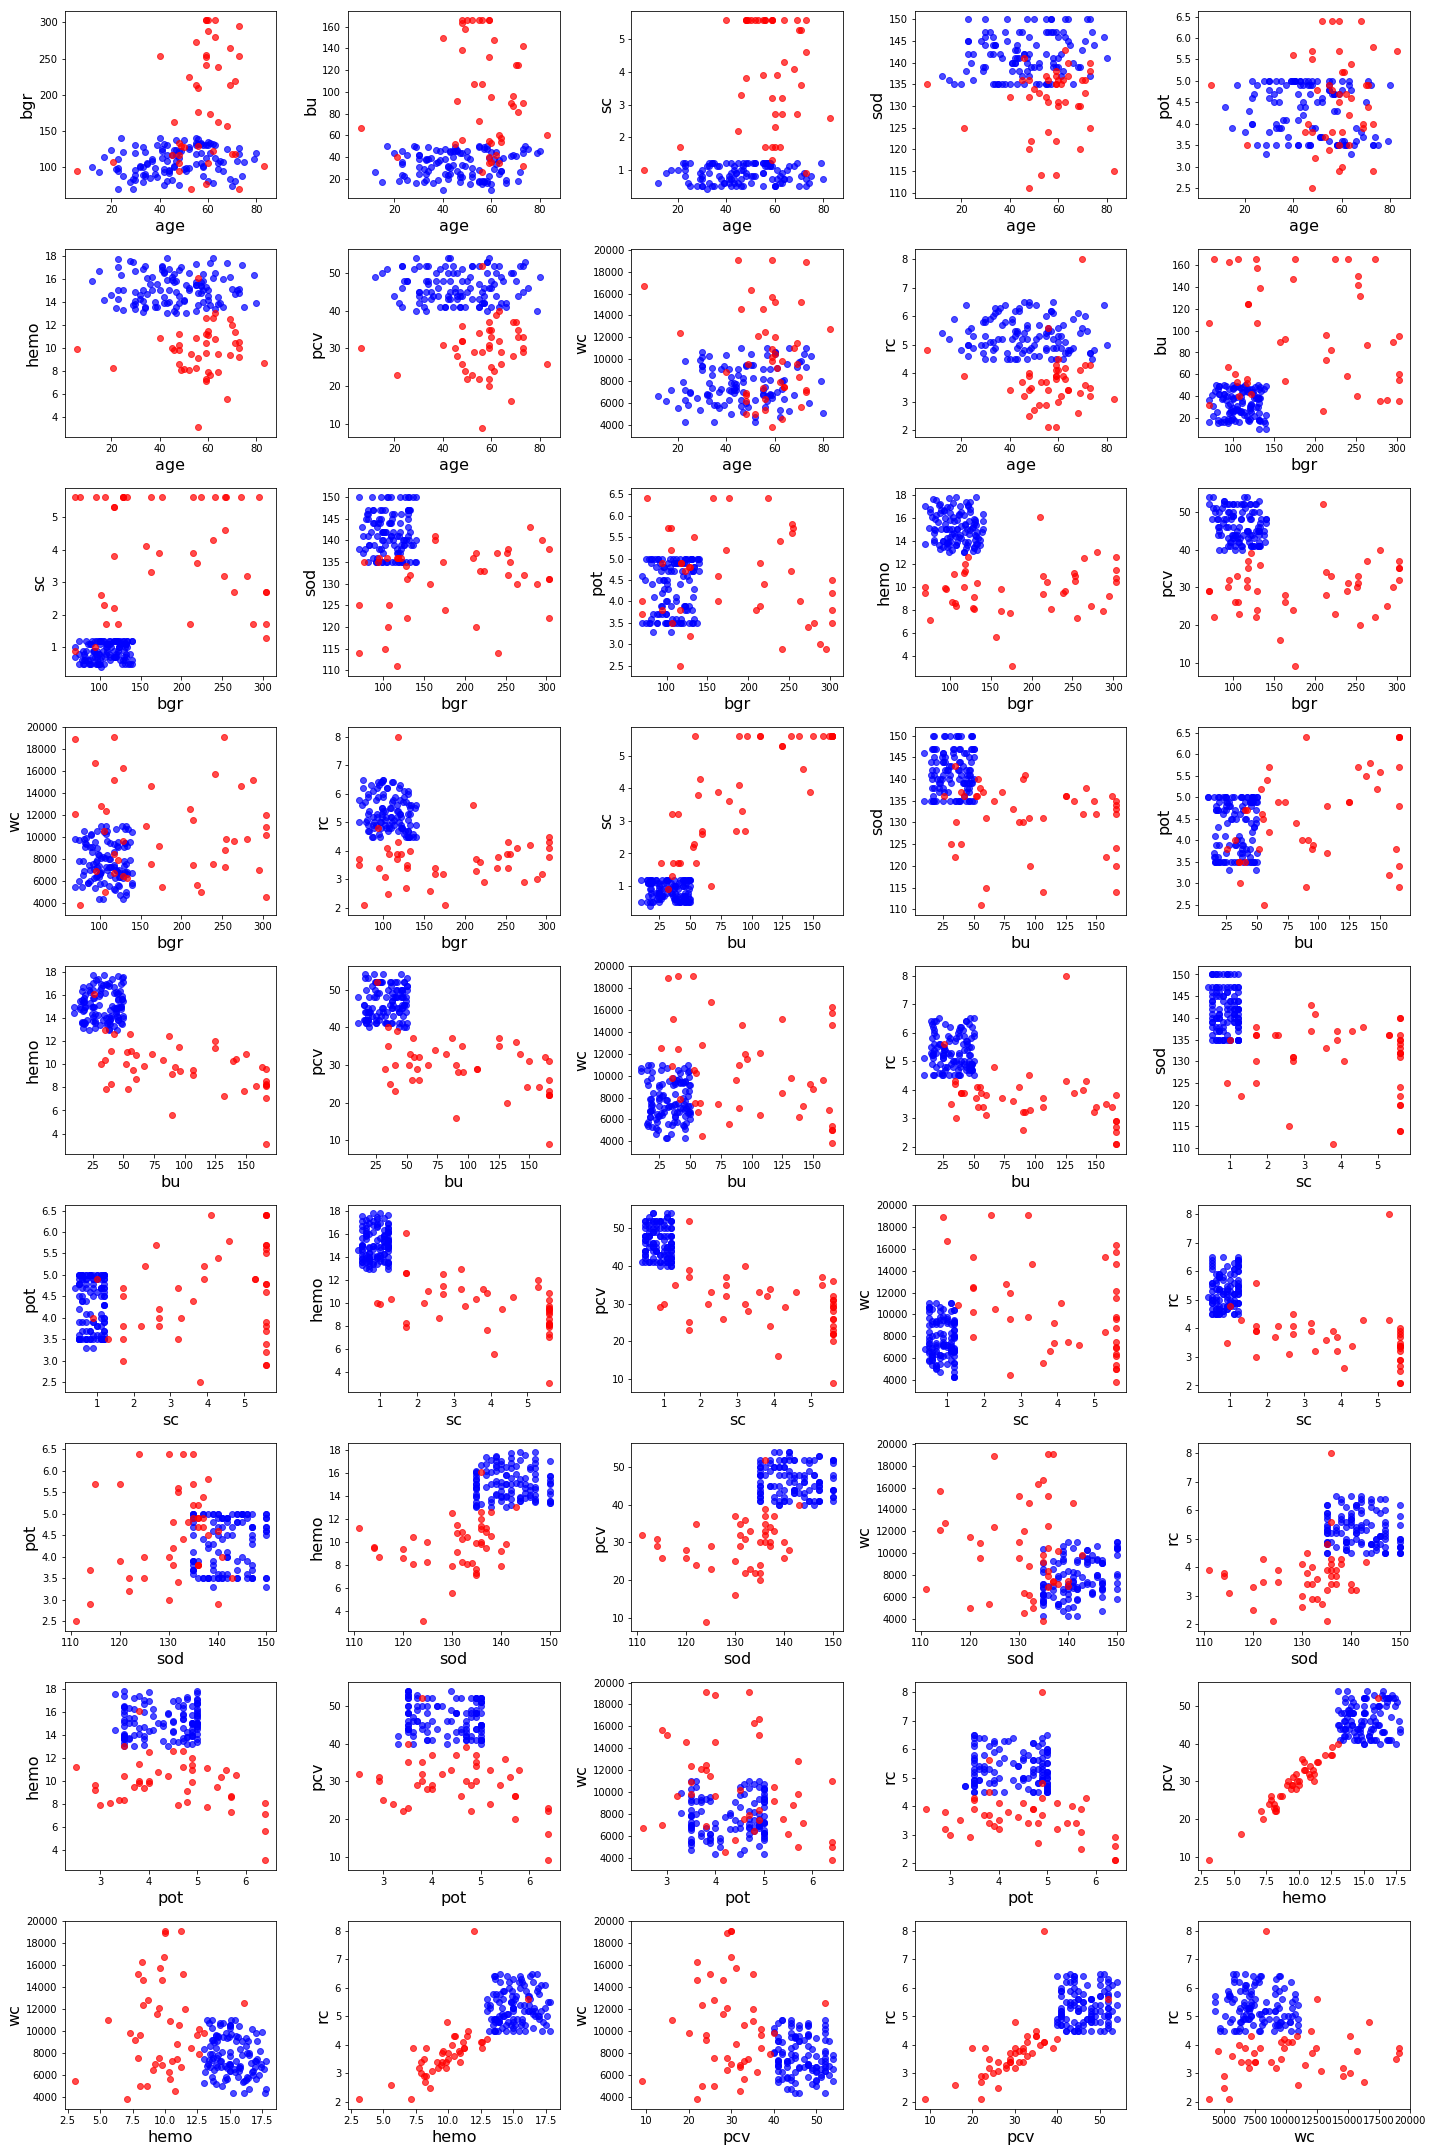

In [16]:
continious=["age", "bgr", "bu", "sc", "sod", "pot", "hemo", "pcv", "wc", "rc", "class"]

plt.figure(figsize=(20, 30))

x=1
for i in range(0, len(continious)-1):
    for j in range(i+1, len(continious)-1):
        plt.subplot(9, 5, x)
        plt.scatter(kd_wins[continious[i]].where(kd_wins[continious]["class"]==0), 
                    kd_wins[continious[j]].where(kd_wins[continious]["class"]==0), color="blue", alpha=0.7)
        plt.scatter(kd_wins[continious[i]].where(kd_wins[continious]["class"]==1), 
                    kd_wins[continious[j]].where(kd_wins[continious]["class"]==1), color="red", alpha=0.7)
        plt.xlabel(continious[i], size=16, color="black")
        plt.ylabel(continious[j], size=16, color="black")
        x+=1
        
plt.tight_layout()
plt.show()

In compliance with scatter plots above;
- 'age' has no relation with other parameters,
- For diagnosed people, ’potassium’ is a stand-alone parameter which has no relation with others.

In addition;
- ’bloodurea’ has a positive linear relation with ’serumcreatinine’,
- ’redbloodcellcount’ has positive linear relations seperately with ’hemoglobin’ and ’packedcellvolume’,
- ’hemoglobin’ has a strong positive linear relation with ’packedcellvolume’.

#### 4.c. Correlation Matrix

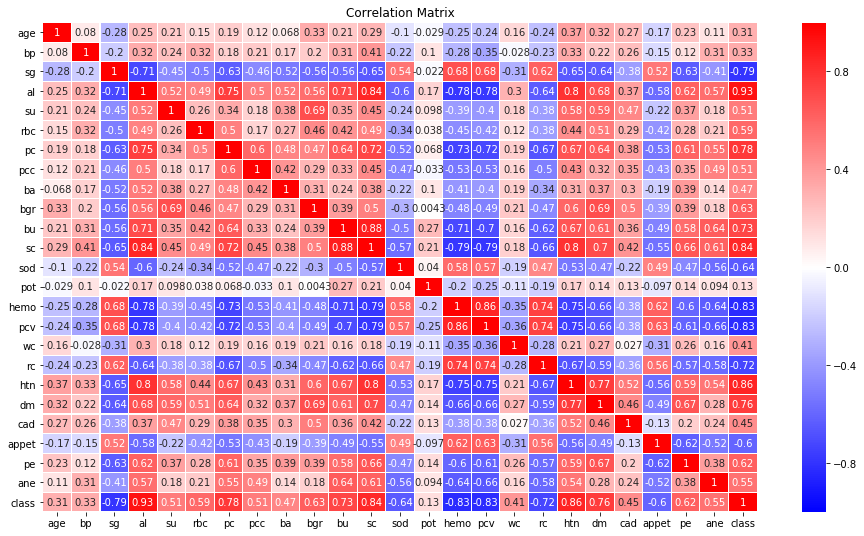

In [17]:
kd_wins_corr=kd_wins.corr()

plt.figure(figsize=(16,9))
sns.heatmap(kd_wins_corr, vmin=-1, vmax=1, cmap="bwr", annot=True, linewidth=0.1)
plt.title("Correlation Matrix")
plt.show()

Correlation matrix mostly confirms histograms an pairplots;
- NO RELATIONS: 'age', ’bloodpressure’, ’potassium’, ’whitebloodcellcount’, ’sugar’, ’redbloodcells’, ’puscellclumps’ and ’bacteria’ have nearly no relations with the target.
- STRONG POSITIVE RELATIONS: ’albumin’, ’puscell’, ’bloodurea’, ’serumcreatinine’, ’hypertension’ and ’diabetesmellitus’ have strong positive relations with the target,
- STRONG NEGATIVE RELATIONS: ’specificgravity’, ’hemoglobin’, ’packedcellvolume’ and ’redbloodcellcount’ have strong negative relations with the target.

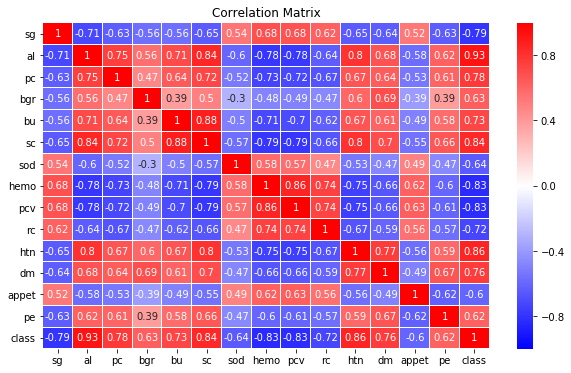

In [18]:
kd_wins_reduced=kd_wins[["sg", "al", "pc", "bgr", "bu", "sc", "sod", "hemo", "pcv", "rc", "htn", "dm", "appet", "pe", "class"]]
kd_wins_corr_reduced=kd_wins_reduced.corr()

plt.figure(figsize=(10,6))
sns.heatmap(kd_wins_corr_reduced, vmin=-1, vmax=1, cmap="bwr", annot=True, linewidth=0.1)
plt.title("Correlation Matrix")
plt.show()

### 5. PRINCIPAL COMPONENTS ANALYSIS (PCA)

###### 1st Approach

In [19]:
kd_std_1=kd_wins_reduced.drop("class", axis=1)
kd_stdized_1=StandardScaler().fit_transform(kd_wins_reduced)

pca_1 = PCA(n_components=8)
pca_1_result=pca_1.fit_transform(kd_stdized_1)

pca_1.explained_variance_ratio_

array([0.67075992, 0.05786084, 0.04525769, 0.03968862, 0.03515427,
       0.02908829, 0.0240175 , 0.0227536 ])

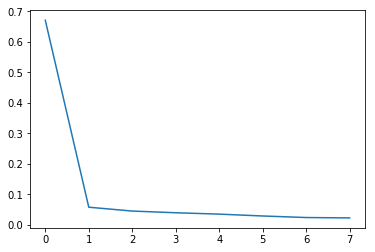

In [20]:
plt.plot(pca_1.explained_variance_ratio_)
plt.show()

###### 2nd Approach

In [21]:
kd_std_2=kd_symptoms.drop("class", axis=1)
kd_stdized_2=StandardScaler().fit_transform(kd_std_2)

pca_2 = PCA(n_components=8)
pca_2_result=pca_2.fit_transform(kd_stdized_2)

pca_2.explained_variance_ratio_

array([0.33300126, 0.14546353, 0.12393093, 0.10971586, 0.08637677,
       0.08497438, 0.07159805, 0.04493923])

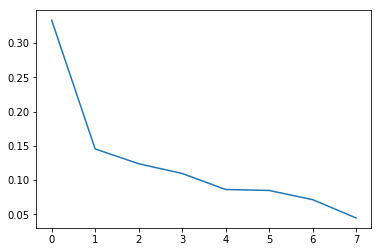

In [22]:
plt.plot(pca_2.explained_variance_ratio_)
plt.show()

In [23]:
len(kd_symptoms)

393

##### 1st Approach
Considering 43 CKD-diagnosed people's parameters, as it is seen above;
- 67.8 % of total variance can be explained with 1 components,
- 78.1 % of total variance can be explained with 3 components,
- 85.6 % of total variance can be explained with 5 components,
- 90.9 % of total variance can be explained with 7 components,
- 93.2 % of total variance can be explained with 8 components,

Optimal component amount can variate among 4-7. It may be thought as 9 or more components are better with more explained variance ratio. But however, this may cause some problems.

43 observation can be too few to set model and to expect it to return good results.

##### 2nd Approach
Very few data has been lost. And;
- 60.2 % of total variance can be explained with 3 components,
- 79.9 % of total variance can be explained with 5 components,
- 95.5 % of total variance can be explained with 7 components,
- 100 % of total variance can be explained with 8 components,

Results are miraculous. But, real success can measured with test results.

### 6. DATA RESAMPLING AND LOGISTIC REGRESSIONS
#### 6.a. Regressions

Defining a function can be useful for repetitive tasks.

In [24]:
def model_test(X, y, types):
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=286, stratify = y)
    
    logreg_model = LogisticRegression()
    logreg_model.fit(X_train, y_train)

    prediction_train = logreg_model.predict(X_train)
    prediction_test = logreg_model.predict(X_test)
    
    train_matrix = confusion_matrix(y_train, prediction_train)
    test_matrix = confusion_matrix(y_test, prediction_test)

    TN_train=train_matrix[0][0]
    TP_train=train_matrix[0][1]
    FN_train=train_matrix[1][0]
    FP_train=train_matrix[1][1]
    
    TN_test=test_matrix[0][0]
    TP_test=test_matrix[0][1]
    FN_test=test_matrix[1][0]
    FP_test=test_matrix[1][1]
    
    row = pd.Series({"Accuracy (Train)":(TN_train + FP_train) / (TN_train + TP_train + FN_train + FP_train), 
                    "Precision (Train)":(FP_train) / (FP_train + TP_train), 
                    "Sensitivity (Train)":(FP_train) / (FP_train + FN_train), 
                    "F1 (Train)":f1_score(y_train, prediction_train),
                    "Type_1 Error % (Train)":(TP_train)*100 / (TP_train + TN_train),
                    "Type_2 Error % (Train)":(FN_train)*100 / (FN_train + FP_train),
                        
                    "Accuracy (Test)":(TN_test + FP_test) / (TN_test + TP_test + FN_test + FP_test), 
                    "Precision (Test)":(FP_test) / (FP_test + TP_test), 
                    "Sensitivity (Test)":(FP_test) / (FP_test + FN_test), 
                    "F1 (Test)":f1_score(y_test, y_test),
                    "Type_1 Error % (Test)":(TP_test)*100 / (TP_test + TN_test),
                    "Type_2 Error & (Test)":(FN_test)*100 / (FN_test + FP_test),},
                    name=types)

    return  row

In [25]:
table=pd.DataFrame()

- Regression with imbalanced dataset and PCA.

In [26]:
X_1_pca=pca_1_result
y_1_pca=kd["class"]

X_2_pca=pca_2_result
y_2_pca=kd_symptoms["class"]

table=table.append(model_test(X_1_pca, y_1_pca, "Imbalanced PCA (1st Appr.)"))
table=table.append(model_test(X_2_pca, y_2_pca, "Imbalanced PCA (2nd Appr.)"))

- Regression with imbalanced dataset.

In [27]:
X_1=kd_wins_reduced.drop("class", axis=1)
y_1=kd_wins_reduced["class"]

X_2=kd_symptoms.drop("class", axis=1)
y_2=kd_symptoms["class"]

table=table.append(model_test(X_1, y_1, "Imbalanced (1st Appr.)"))
table=table.append(model_test(X_2, y_2, "Imbalanced (2nd Appr.)"))

- Regression with cloned dataset.

In [28]:
normal_1=kd_wins_reduced[kd_wins_reduced["class"]==0]
cloned_1=kd_wins_reduced[kd_wins_reduced["class"]==1]
normal_2=kd_symptoms[kd_symptoms["class"]==0]
cloned_2=kd_symptoms[kd_symptoms["class"]==1]

cloned_data_1=resample(cloned_1, replace=True, random_state=286, n_samples=len(normal_1))
cloned_data_2=resample(cloned_2, replace=True, random_state=286, n_samples=len(normal_2))

equal_1=pd.concat([normal_1, cloned_data_1])
equal_2=pd.concat([normal_2, cloned_data_2])

X_cl_1 = equal_1.drop('class', axis=1)
y_cl_1 = equal_1['class']
X_cl_2 = equal_2.drop('class', axis=1)
y_cl_2 = equal_2['class']

table=table.append(model_test(X_cl_1, y_cl_1, "Cloned (1st Appr.)"))
table=table.append(model_test(X_cl_2, y_cl_2, "Cloned (2nd Appr.)"))

- Regression with SMOTE resampling method.

In [29]:
X_SM_1=kd_wins_reduced.drop("class", axis=1)
y_SM_1=kd_wins_reduced["class"]
X_SM_2=kd_symptoms.drop("class", axis=1)
y_SM_2=kd_symptoms["class"]

sm_1=SMOTE(random_state=286, ratio=1)
X_sm_1, y_sm_1=sm_1.fit_sample(X_SM_1, y_SM_1)
sm_2=SMOTE(random_state=286, ratio=1)
X_sm_2, y_sm_2=sm_2.fit_sample(X_SM_2, y_SM_2)

table=table.append(model_test(X_sm_1, y_sm_1, "SMOTE (1st Appr.)"))
table=table.append(model_test(X_sm_2, y_sm_2, "SMOTE (2nd Appr.)"))

- Regression with ADASYN resampling method.

In [30]:
X_ADA_1=kd_wins_reduced.drop("class", axis=1)
y_ADA_1=kd_wins_reduced["class"]
X_ADA_2=kd_symptoms.drop("class", axis=1)
y_ADA_2=kd_symptoms["class"]

ada=ADASYN()
X_ada_1, y_ada_1=ada.fit_sample(X_ADA_1, y_ADA_1)
X_ada_2, y_ada_2=ada.fit_sample(X_ADA_2, y_ADA_2)

table=table.append(model_test(X_ada_1, y_ada_1, "ADASYN (1st Appr.)"))
table=table.append(model_test(X_ada_2, y_ada_2, "ADASYN (2nd Appr.)"))

#### 6.b. Results

In [31]:
table

,Accuracy (Test),Accuracy (Train),F1 (Test),F1 (Train),Precision (Test),Precision (Train),Sensitivity (Test),Sensitivity (Train),Type_1 Error % (Test),Type_1 Error % (Train),Type_2 Error % (Train),Type_2 Error & (Test)
Imbalanced PCA (1st Appr.),1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,0.0,0.0,0.000000,0.000000
Imbalanced PCA (2nd Appr.),0.936709,0.907643,1.0,0.921833,1.0,1.0,0.900000,0.855000,0.0,0.0,14.500000,10.000000
Imbalanced (1st Appr.),0.968750,1.000000,1.0,1.000000,1.0,1.0,0.888889,1.000000,0.0,0.0,0.000000,11.111111
Imbalanced (2nd Appr.),0.936709,0.907643,1.0,0.921833,1.0,1.0,0.900000,0.855000,0.0,0.0,14.500000,10.000000
Cloned (1st Appr.),0.978261,1.000000,1.0,1.000000,1.0,1.0,0.956522,1.000000,0.0,0.0,0.000000,4.347826
Cloned (2nd Appr.),0.896552,0.925439,1.0,0.919431,1.0,1.0,0.793103,0.850877,0.0,0.0,14.912281,20.689655
SMOTE (1st Appr.),1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,0.0,0.0,0.000000,0.000000
SMOTE (2nd Appr.),0.900000,0.930000,1.0,0.924731,1.0,1.0,0.800000,0.860000,0.0,0.0,14.000000,20.000000
ADASYN (1st Appr.),1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.000000,0.0,0.0,0.000000,0.000000
ADASYN (2nd Appr.),0.898148,0.936916,1.0,0.927614,1.0,1.0,0.780000,0.865000,0.0,0.0,13.500000,22.000000


Obviously seen;
- 2nd approach lacks of some useful information and all the way, it is worse than the 1st approach,
- 1st approach can preoccupy with overfitting due to perfect train results. But, it also has best test results, too.
- Explained variance ratio does not mean everything. It only can give an idea. However, test results are unique to measure the real success.

Best models are : (All for 1st approach)
- Imbalanced PCA,
- SMOTE,
- ADASYN.

#### 6.c. Cross Validation

- Best models should be validated whether they are really the best.

In [32]:
cv=cross_validate(estimator=LogisticRegression(), X=X_1, y=y_1, cv=5)
print("Imbalanced PCA")
print("-"*30, "\n")
print("Training Scores     :", cv['train_score'], sep = '\t')
print("Mean Training Score :", cv['train_score'].mean(), sep = '\t')
print("\nTest Scores         :", cv['test_score'], sep = '\t')
print("Mean Test Score     :", cv['test_score'].mean(), sep = '\t')

Imbalanced PCA
------------------------------ 

Training Scores     :	[1. 1. 1. 1. 1.]
Mean Training Score :	1.0

Test Scores         :	[0.96875 0.96875 1.      1.      1.     ]
Mean Test Score     :	0.9875


In [33]:
cv=cross_validate(estimator=LogisticRegression(), X=X_sm_1, y=y_sm_1, cv=5)
print("SMOTE")
print("-"*30, "\n")
print("Training Scores     :", cv['train_score'], sep = '\t')
print("Mean Training Score :", cv['train_score'].mean(), sep = '\t')
print("\nTest Scores         :", cv['test_score'], sep = '\t')
print("Mean Test Score     :", cv['test_score'].mean(), sep = '\t')

SMOTE
------------------------------ 

Training Scores     :	[1. 1. 1. 1. 1.]
Mean Training Score :	1.0

Test Scores         :	[0.97826087 1.         1.         1.         1.        ]
Mean Test Score     :	0.9956521739130434


In [34]:
cv=cross_validate(estimator=LogisticRegression(), X=X_ada_1, y=y_ada_1, cv=5)
print("ADASYN")
print("-"*30, "\n")
print("Training Scores     :", cv['train_score'], sep = '\t')
print("Mean Training Score :", cv['train_score'].mean(), sep = '\t')
print("\nTest Scores         :", cv['test_score'], sep = '\t')
print("Mean Test Score     :", cv['test_score'].mean(), sep = '\t')

ADASYN
------------------------------ 

Training Scores     :	[1. 1. 1. 1. 1.]
Mean Training Score :	1.0

Test Scores         :	[0.97826087 1.         1.         1.         1.        ]
Mean Test Score     :	0.9956521739130434


###### There are 2 best models left:
>###### - SMOTE resampled model,
>###### - ADASYN resampled model.